In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score


In [14]:
model_df = pd.read_csv('model_preds.csv')
gt_df = pd.read_csv('ground_truths.csv')
import pickle
with open('im_names.pkl', 'rb') as f:
    im_names = pickle.load(f)

# Actual per patient data
expert_df = pd.read_csv('bc4.csv')
truth_df = pd.read_csv('groundtruth.csv')

In [15]:
class_names = ['im_index', 'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
disease_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
model_df.columns = class_names
gt_df.columns = class_names
display(model_df)

,im_index,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,0,0.032154,0.059780,0.302711,0.553119,0.008942,0.367505,0.277982,0.070155,0.470467,0.021062,0.581702,0.003649,0.012781,0.956308
1,1,0.095612,0.063368,0.095019,0.418463,0.040424,0.408792,0.175145,0.132434,0.484590,0.063902,0.290641,0.013777,0.035408,0.339339
2,2,0.002129,0.047629,0.497672,0.689397,0.015805,0.841252,0.251036,0.170970,0.449822,0.011705,0.841706,0.005777,0.024511,0.251686
3,3,0.274531,0.104259,0.518217,0.182351,0.018398,0.109515,0.070042,0.048136,0.218004,0.012932,0.120700,0.021547,0.037452,0.908303
4,4,0.039661,0.091054,0.230300,0.606906,0.090755,0.371806,0.240587,0.288980,0.268316,0.068011,0.489575,0.035938,0.022309,0.274403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,663,0.011048,0.060877,0.367766,0.688289,0.021680,0.810047,0.151639,0.349521,0.209190,0.039538,0.156541,0.021064,0.014627,0.859260
664,664,0.357680,0.088913,0.044297,0.254880,0.057094,0.037478,0.092766,0.062399,0.233433,0.139328,0.147095,0.015332,0.050995,0.423609
665,665,0.160925,0.079370,0.055493,0.376040,0.034616,0.249435,0.126903,0.127064,0.381733,0.059037,0.083335,0.007045,0.041175,0.228897
666,666,0.008390,0.032112,0.365313,0.519742,0.013560,0.874667,0.154404,0.183462,0.389510,0.011564,0.594937,0.005146,0.010473,0.808507


In [16]:
def add_df_disease_metrics (true_df, pred_df, metric_df = None, col_name = None, metric_func=None):
    if metric_func == None: # gets list_true, list_pred
        metric_func = roc_auc_score
    if type(metric_df) == type(None):
        metric_df = pd.DataFrame()
        metric_df['diagnosis'] = disease_names
    metric_list = []
    for diagnosis in disease_names:
        metric = metric_func(list(true_df[diagnosis]),list(pred_df[diagnosis]))
        metric_list.append(metric)
    metric_df[col_name] = metric_list
    return metric_df

D:\WORK\EthicalRAI\project_data\CheXpert-v1.0-small/test/patient64741/study1/view1_frontal.jpg
668


<AxesSubplot:xlabel='diagnosis'>

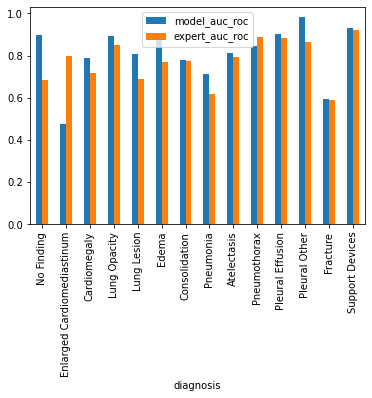

In [17]:
patient_ids = []
fixed = []
for lsname in im_names:
    fixed.extend(lsname)
print(fixed[0])
print(len(fixed))
for fileName in fixed:
    #print(fileName.split('/')[2])
    pid = fileName.split('/')[2]
    patient_ids.append(pid)

# Patient sum probability diagnosis
model_df['pid']=patient_ids
patient_model_df = model_df.groupby('pid').max().drop(['im_index'], axis=1)

gt_df['pid']=patient_ids
patient_gt_df = gt_df.groupby('pid').max().drop(['im_index'], axis=1)


metrics_df = add_df_disease_metrics(true_df=patient_gt_df, pred_df=patient_model_df, col_name = 'model_auc_roc')
add_df_disease_metrics(true_df=truth_df, pred_df=expert_df, metric_df=metrics_df, col_name = 'expert_auc_roc')

#sns.barplot(data=metrics_df, x='diagnosis', y='model_auc_roc')
metrics_df.plot.bar(x='diagnosis', y=['model_auc_roc', 'expert_auc_roc'], rot=90)

In [18]:
model_df['pid']=patient_ids
model_df_per_patient = model_df.groupby('pid').sum().drop(['im_index'], axis=1)
#display(model_df)

In [19]:
def check_accuracy(gt, df_pred):
    accuracy_list = []
    for col in disease_names:
        accuracy_per_desease = []
        for patient_gt, patient_pred in zip(gt[col], df_pred[col]):
            #print(str(df_pred[patient][col]))
            #print(str(gt[patient][col]))
            if (patient_pred>0.5 and patient_gt==1) or (patient_pred<=0.5 and patient_gt==0):
                accuracy_per_desease.append(1)
            else:
                accuracy_per_desease.append(0)
        accuracy_list.append(accuracy_per_desease)
    return accuracy_list

In [20]:
def print_accuracy_per_desease(accu_list):
    final_accu = []
    for desease_index in range(len(disease_names)):
        accu = (sum(accu_list[desease_index]))/len(accu_list[desease_index])
        final_accu.append(accu)
        print("accuracy per disease " + str(disease_names[desease_index]) + " is: " + str(accu))
    return final_accu

In [21]:
expert_accuracy_list = check_accuracy(truth_df, expert_df)
print ("expert accuracies: ")
expert_accuracy_final = print_accuracy_per_desease(expert_accuracy_list)

model_accuracy_list = check_accuracy(truth_df, model_df_per_patient)
print ("model accuracies: ")
model_accuracy_final = print_accuracy_per_desease(model_accuracy_list)



expert accuracies: 
accuracy per disease No Finding is: 0.916
accuracy per disease Enlarged Cardiomediastinum is: 0.796
accuracy per disease Cardiomegaly is: 0.81
accuracy per disease Lung Opacity is: 0.848
accuracy per disease Lung Lesion is: 0.99
accuracy per disease Edema is: 0.87
accuracy per disease Consolidation is: 0.876
accuracy per disease Pneumonia is: 0.944
accuracy per disease Atelectasis is: 0.792
accuracy per disease Pneumothorax is: 0.99
accuracy per disease Pleural Effusion is: 0.92
accuracy per disease Pleural Other is: 0.978
accuracy per disease Fracture is: 0.972
accuracy per disease Support Devices is: 0.926
model accuracies: 
accuracy per disease No Finding is: 0.878
accuracy per disease Enlarged Cardiomediastinum is: 0.494
accuracy per disease Cardiomegaly is: 0.736
accuracy per disease Lung Opacity is: 0.722
accuracy per disease Lung Lesion is: 0.984
accuracy per disease Edema is: 0.808
accuracy per disease Consolidation is: 0.918
accuracy per disease Pneumonia i

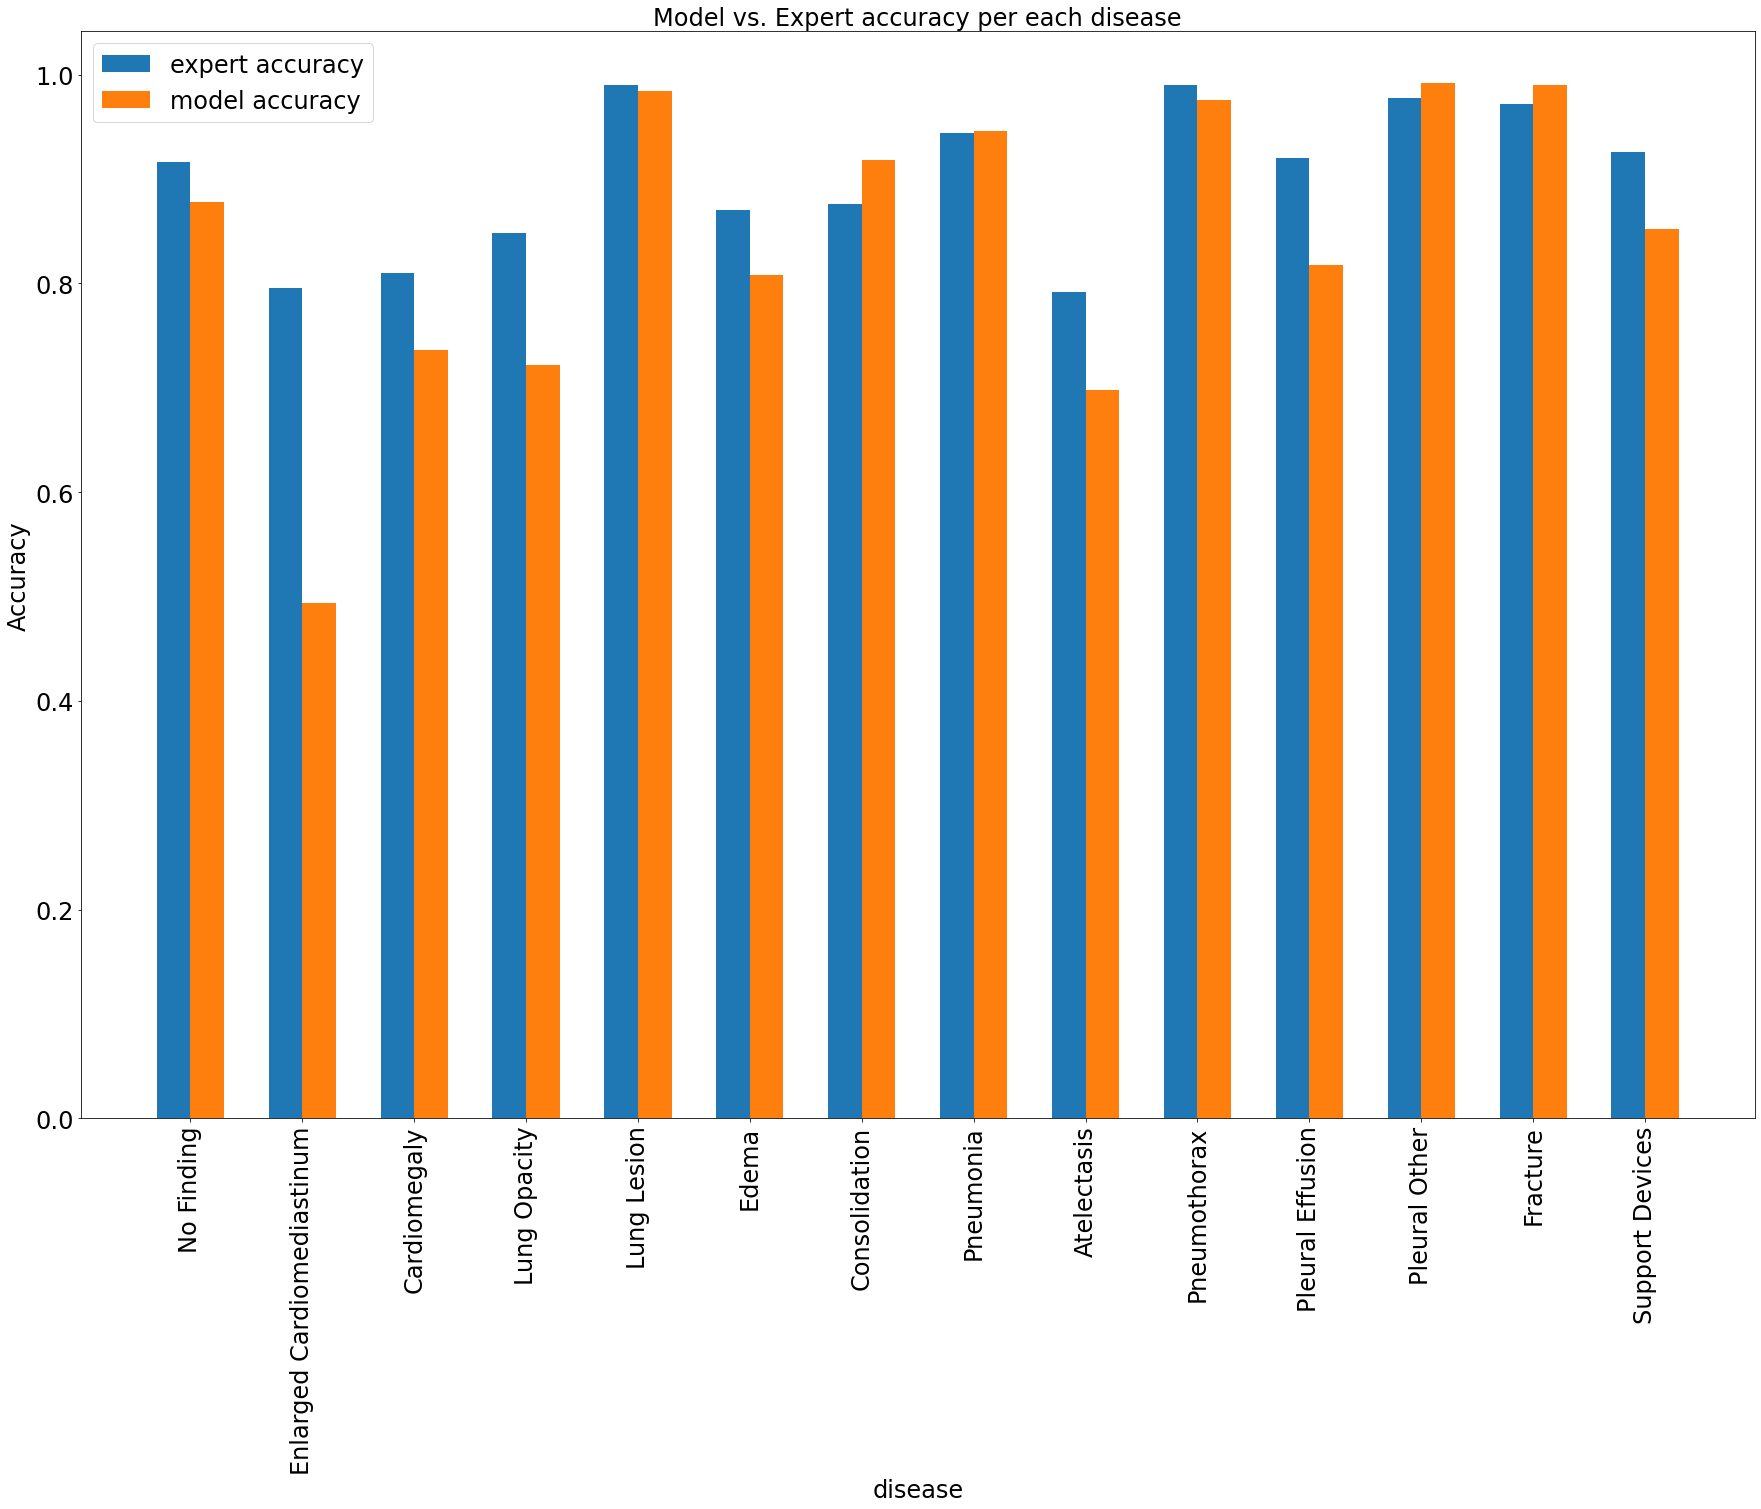

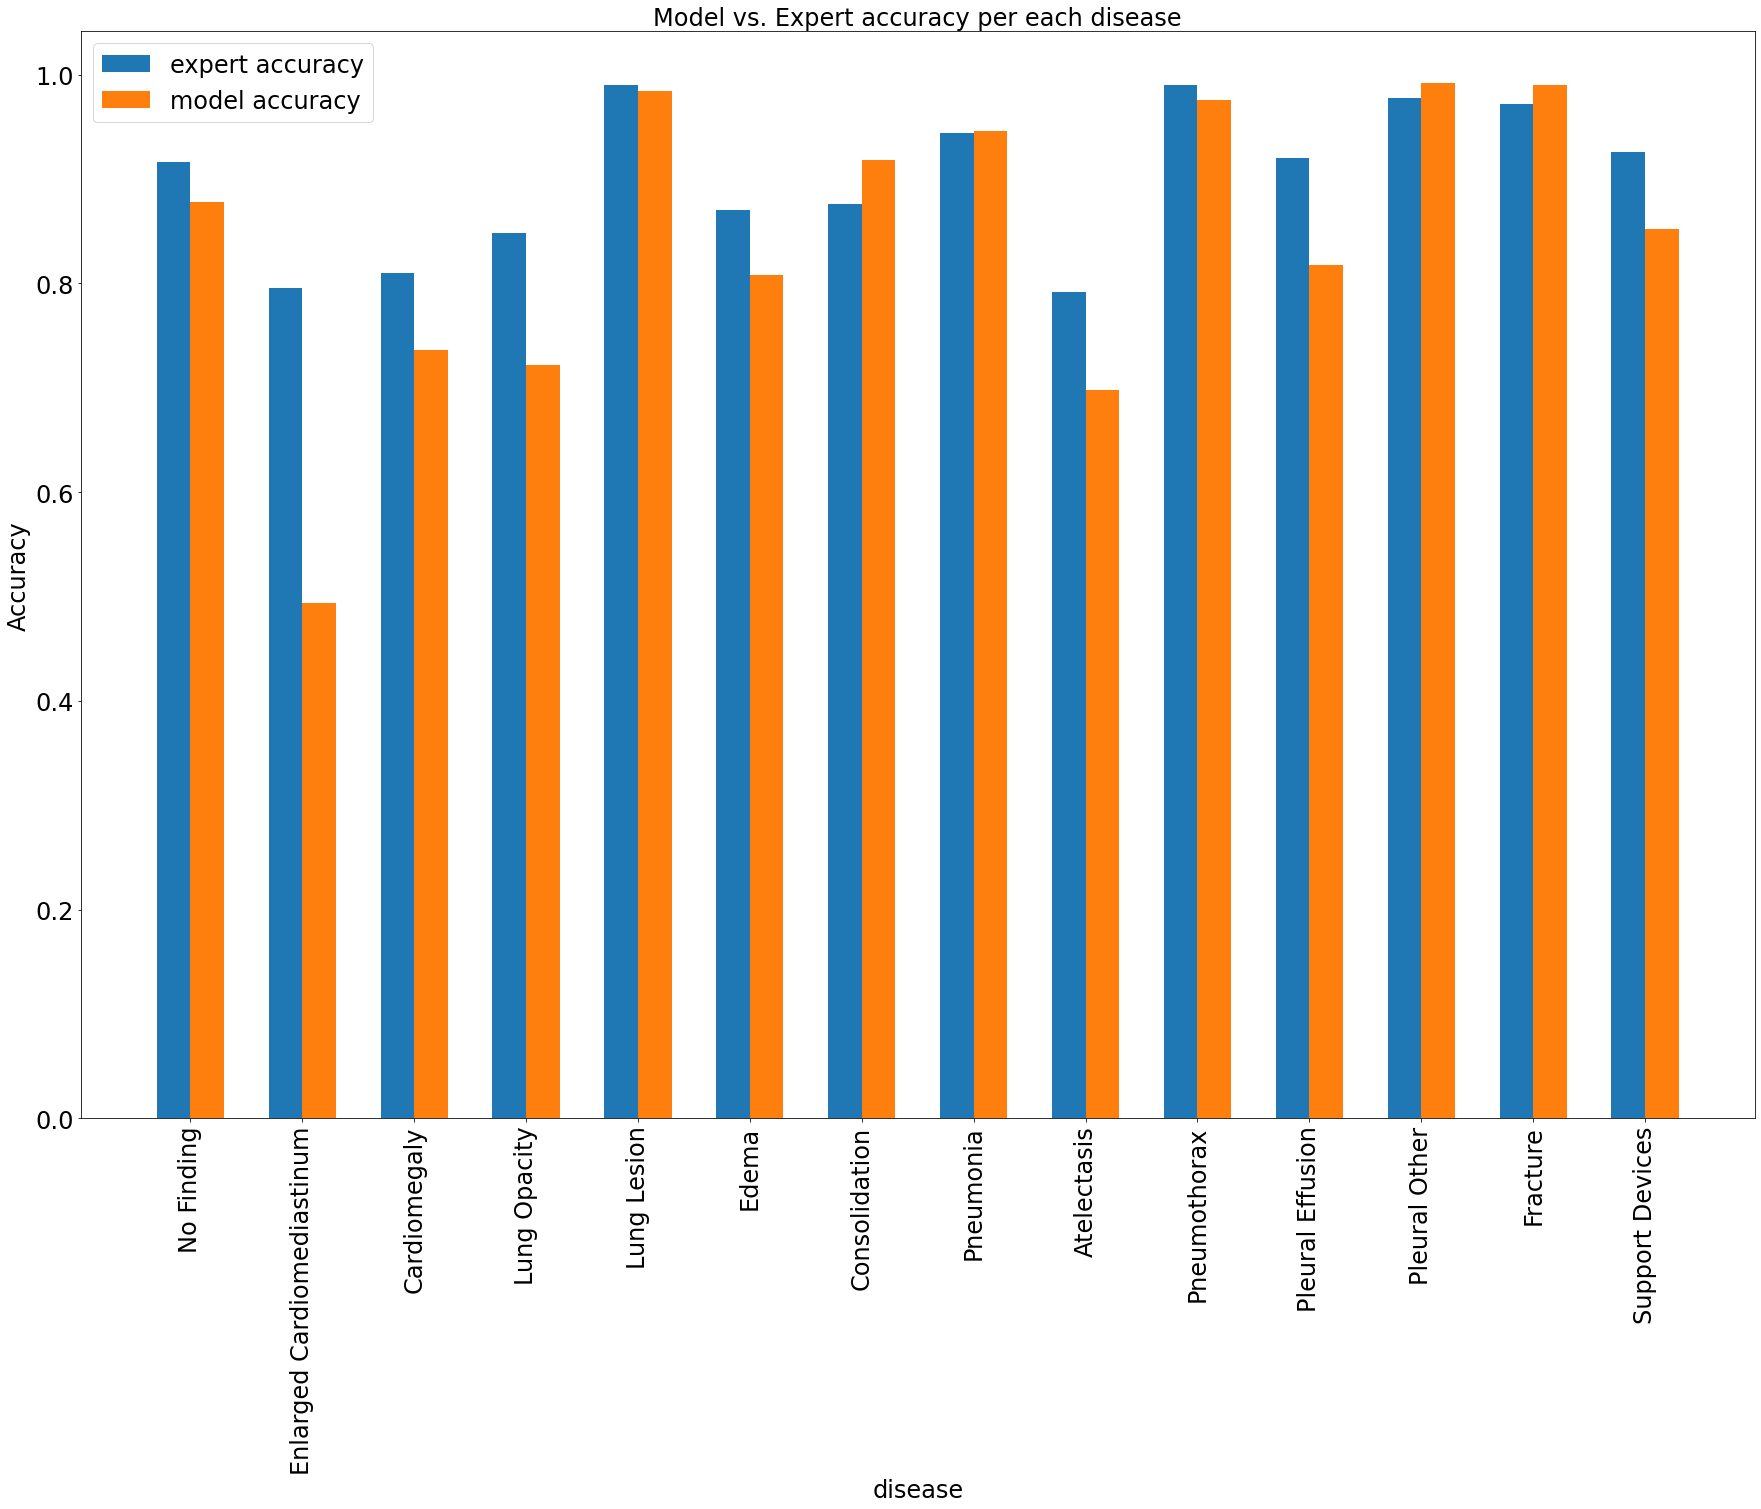

In [22]:
X = disease_names
ycont = expert_accuracy_final
ztest = model_accuracy_final
  
X_axis = np.arange(len(X))
plt.figure(figsize=(30, 20))
#plt.bar(X_axis, ycont, 0.4, label = 'model accuracy')
#plt.bar(X_axis, ztest, 0.4, label = 'expert accuracy')
plt.bar(X_axis - 0.15, ycont, 0.3, label = 'expert accuracy')
plt.bar(X_axis + 0.15, ztest, 0.3, label = 'model accuracy')
plt.tick_params(axis='x',  labelsize=24)  
plt.tick_params(axis='y', labelsize=24)

plt.xticks(X_axis, X,rotation='vertical')
plt.xlabel("disease",fontsize=24)
plt.ylabel("Accuracy",fontsize=24)
plt.title("Model vs. Expert accuracy per each disease",fontsize=24)
plt.legend(fontsize=24)
plt.show()

129
331
210
178
27
98
65
31
210
19
112
17
15
148


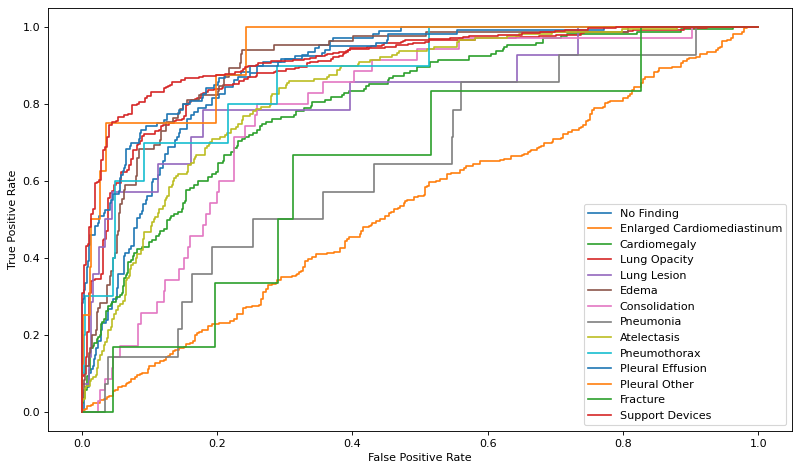

129
331
210
178
27
98
65
31
210
19
112
17
15
148


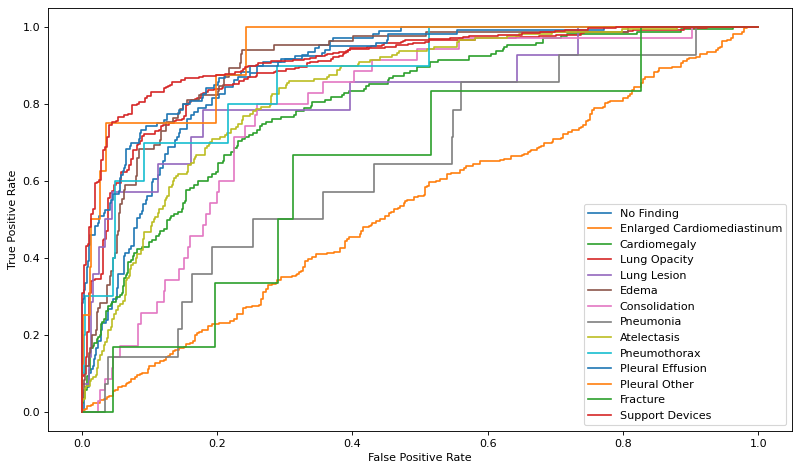

In [23]:
from sklearn.metrics import roc_curve

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(len(thresholds))



plt.figure(figsize=(12, 7), dpi=80)

for dn in disease_names:
    plot_roc_curve(gt_df[dn], model_df[dn])    

plt.legend(disease_names)


In [29]:
# find threshold per disease
import numpy as np
def find_apply_thresh(true_df, pred_df, data_df):
    out_df = pd.DataFrame()
    for diagnosis in disease_names:
        x,y,thres = roc_curve(list(true_df[diagnosis]),list(pred_df[diagnosis]))
        source = np.array((0,1))
        best_thres = thres[np.argmin([ np.linalg.norm( source - p) for p in zip(x,y)])]
        out_df[diagnosis] = data_df[diagnosis].apply(lambda x: 1 if x>=best_thres else 0)

    return out_df

patient_model_df_threshed = find_apply_thresh(true_df=patient_gt_df, pred_df=patient_model_df, data_df=patient_model_df.copy())

Text(0.5, 1.0, 'Accuracy comparison of model and expert')

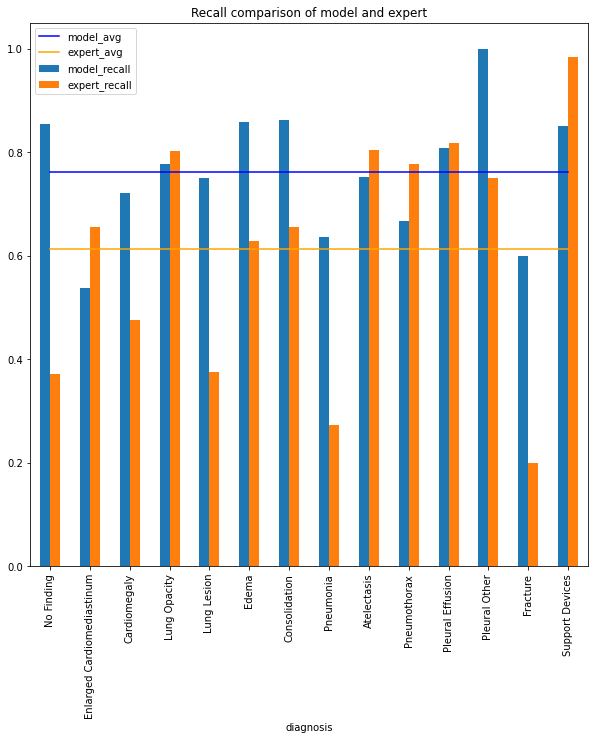

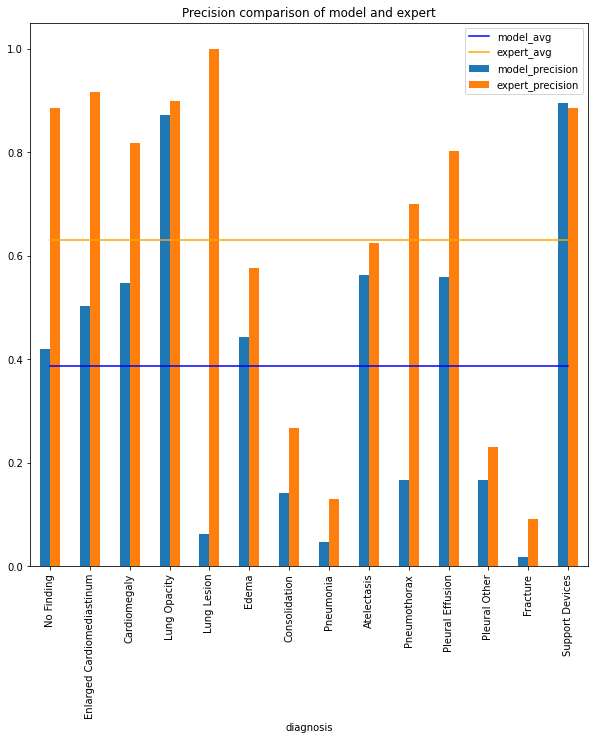

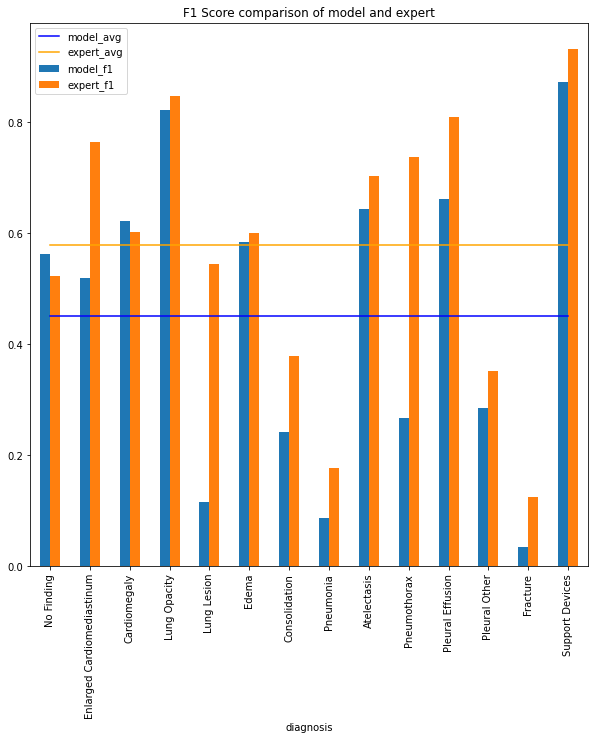

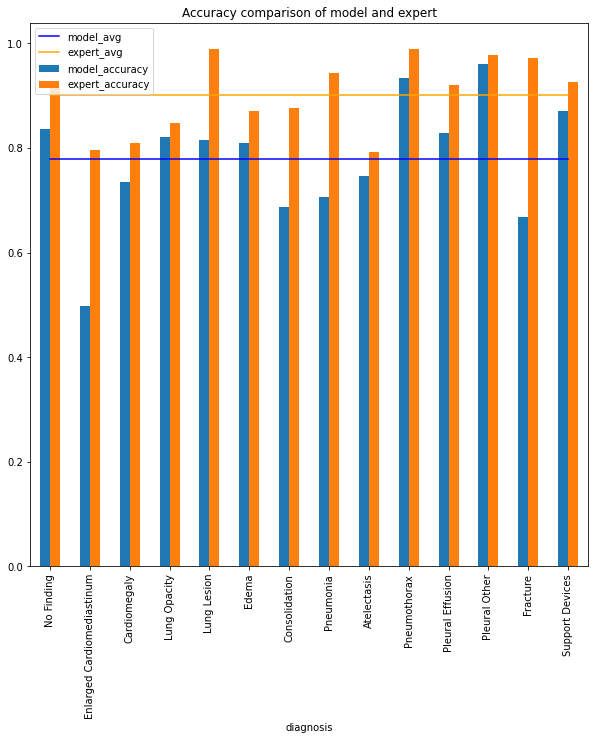

In [47]:
from sklearn.metrics import precision_score, f1_score, accuracy_score

def create_comparison(score_func,title_model,title_human):

    metrics_df = add_df_disease_metrics(true_df=patient_gt_df, pred_df=patient_model_df_threshed, col_name = title_model, metric_func=score_func)
    add_df_disease_metrics(true_df=truth_df, pred_df=expert_df, metric_df=metrics_df, col_name = title_human, metric_func=score_func)


    metrics_df.plot.bar(x='diagnosis', y=[title_model, title_human], rot=90,figsize=(10,10))
    model_avg = np.mean(list(metrics_df[title_model]))
    expert_avg = np.mean(list(metrics_df[title_human]))
    plt.plot(np.arange(0,14), [model_avg]*len(np.arange(0,14)), label='model_avg', c='blue')
    plt.plot(np.arange(0,14), [expert_avg]*len(np.arange(0,14)), label='expert_avg', c='orange')
    plt.legend()

create_comparison(recall_score,'model_recall','expert_recall')
plt.title('Recall comparison of model and expert')

create_comparison(precision_score,'model_precision','expert_precision')
plt.title('Precision comparison of model and expert')

create_comparison(f1_score,'model_f1','expert_f1')
plt.title('F1 Score comparison of model and expert')

create_comparison(accuracy_score,'model_accuracy','expert_accuracy')
plt.title('Accuracy comparison of model and expert')